<a href="https://colab.research.google.com/github/shanikairoshi/DUQFL/blob/main/QFL_best_avg_Genome_improvedMaxiter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Federated Learning with Weighted Aggregation
This notebook demonstrates how to implement different weighting mechanisms for federated learning.
We'll experiment with fixed weighting, performance-based weighting, and dynamic scaling to aggregate
model weights across


In [1]:

%%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer
%%capture
!pip install qiskit
!pip install qiskit_machine_learning

In [12]:

from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm

test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
len(data_set)

from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm

test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
len(data_set)

from collections import defaultdict
import numpy as np

word_size = 40
word_combinations = defaultdict(int)
iteration = 1
for text, _ in data_set:
    for i in range(len(text)):
        word = text[i:i+word_size]
        if word_combinations.get(word) is None:
          word_combinations[word] = iteration
          iteration += 1



print("First sample int the data_set variable: ")
print(data_set[0])

print("\nFirst 5 samples in the word_combinations dict.")
for key, value in list(word_combinations.items())[:5]:
    print(key, value)


import numpy as np
# Preprocess the training set
np_data_set = []
for i in range(len(data_set)):
    sequence, label = data_set[i]
    sequence = sequence.strip()  # Remove any leading/trailing whitespace
    words = [sequence[i:i + word_size] for i in range(0, len(sequence), word_size)]  # Split the sequence into 4-letter words
    int_sequence = np.array([word_combinations[word] for word in words])
    data_point = {'sequence': int_sequence, 'label': label}
    np_data_set.append(data_point)


print("First 5 samples of encoded data:")
np_data_set[:5]


np.random.shuffle(np_data_set)
print("First 5 samples of encoded shuffled data:")
np_data_set[:5]
from sklearn.preprocessing import MinMaxScaler

sequences = np.array([item['sequence'] for item in np_data_set])
sequences = np.vstack(sequences)

scaler = MinMaxScaler()

sequences_scaled = scaler.fit_transform(sequences)

for i, item in enumerate(np_data_set):
    item['sequence'] = sequences_scaled[i]

print("First 5 samples of scaled encoded shuffled data:")
np_data_set[:5]


np_train_data = np_data_set[:5000] #change data from 15000 to 5000
np_test_data = np_data_set[-5000:]

print(f"Length of np_train_data: {len(np_train_data)}")
print(f"Length of np_test_data: {len(np_test_data)}")

test_sequences = [data_point["sequence"] for data_point in np_test_data]
test_labels = [data_point["label"] for data_point in np_test_data]
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)



First sample int the data_set variable: 
('TGTCACCTTGCAGTCCCCCTTTGATTTTTTTCTTGTTTTTTTCAGATTGATCCTTTTTCTGATAGTATACCTTCCCACTGCTGAGCTCTAATTCATTAAAAGAAAAAATGTGGGCCACATTTCTGCAGCAGCCCCTTTCCTTAGATTGTAAATTCTAGGGGCAGACTTAGCTGAGGAAGGGAGGTGAATGCACAGCGGGC', 0)

First 5 samples in the word_combinations dict.
TGTCACCTTGCAGTCCCCCTTTGATTTTTTTCTTGTTTTT 1
GTCACCTTGCAGTCCCCCTTTGATTTTTTTCTTGTTTTTT 2
TCACCTTGCAGTCCCCCTTTGATTTTTTTCTTGTTTTTTT 3
CACCTTGCAGTCCCCCTTTGATTTTTTTCTTGTTTTTTTC 4
ACCTTGCAGTCCCCCTTTGATTTTTTTCTTGTTTTTTTCA 5
First 5 samples of encoded data:
First 5 samples of encoded shuffled data:
First 5 samples of scaled encoded shuffled data:
Length of np_train_data: 5000
Length of np_test_data: 5000


In [3]:
def split_dataset_for_epochs(num_clients, num_epochs, train_data, test_data, samples_per_epoch):
    """
    Split the dataset across multiple epochs and clients.

    Args:
        num_clients (int): Number of clients.
        num_epochs (int): Number of epochs.
        train_data (list): List of training data points.
        test_data (list): List of test data points.
        samples_per_epoch (int): Number of samples per epoch.

    Returns:
        list: A list of Client objects with assigned data for each epoch.
    """
    clients = []

    # Split the training data across epochs and clients
    train_samples_per_client = len(train_data) // num_clients

    for i in range(num_clients):
        client_data_for_epochs = []

        for epoch in range(num_epochs):
            start_idx = (i * num_epochs * samples_per_epoch) + (epoch * samples_per_epoch)
            end_idx = (i * num_epochs * samples_per_epoch) + ((epoch + 1) * samples_per_epoch)
            client_data_for_epochs.append(train_data[start_idx:end_idx])

        # Assign test data to each client
        test_samples_per_client = len(test_data) // num_clients
        test_start_idx = i * test_samples_per_client
        test_end_idx = (i + 1) * test_samples_per_client
        client_test_data = test_data[test_start_idx:test_end_idx]

        # Create a Client instance with epoch-specific data
        clients.append(Client(client_data_for_epochs, client_test_data))

    return clients


In [4]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import BackendSampler
from qiskit_algorithms.optimizers import SPSA
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
from qiskit_aer import Aer

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import BackendSampler
from qiskit_algorithms.optimizers import SPSA
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt


num_clients = 5
num_epochs = 10
max_train_iterations = 100
samples_per_epoch=100
backend = Aer.get_backend('aer_simulator')

class Client:
   def __init__(self, data, test_data):  # Add test_data to __init__
        self.data = data
        self.test_data = test_data  # Store test_data as an attribute
        self.models = []
        self.train_scores = []
        self.test_scores = []
        self.primary_model = None

def split_dataset_for_epochs(num_clients, num_epochs, train_data, test_data, samples_per_epoch, data_proportions):
    """
    Split the dataset across multiple epochs and clients based on data proportions.

    Args:
        num_clients (int): Number of clients.
        num_epochs (int): Number of epochs.
        train_data (list): List of training data points.
        test_data (list): List of test data points.
        samples_per_epoch (int): Number of samples per epoch.
        data_proportions (list): Proportion of data assigned to each client (length must equal num_clients).

    Returns:
        list: A list of Client objects with assigned data for each epoch.
    """
    assert len(data_proportions) == num_clients, "Length of data_proportions must match num_clients."
    assert abs(sum(data_proportions) - 1.0) < 1e-6, "Data proportions must sum to 1."

    clients = []
    total_train_samples = len(train_data)

    # Compute the number of training samples for each client based on proportions
    train_samples_per_client = [int(total_train_samples * prop) for prop in data_proportions]

    train_start_idx = 0

    for i in range(num_clients):
        client_data_for_epochs = []

        # Get the number of samples for this client
        client_train_samples = train_samples_per_client[i]
        train_end_idx = train_start_idx + client_train_samples

        # Split client's training data across epochs
        for epoch in range(num_epochs):
            start_idx = train_start_idx + (epoch * samples_per_epoch)
            end_idx = min(train_start_idx + ((epoch + 1) * samples_per_epoch), train_end_idx)
            client_data_for_epochs.append(train_data[start_idx:end_idx])

        train_start_idx = train_end_idx  # Update for the next client

        # Split test data equally among clients
        test_samples_per_client = len(test_data) // num_clients
        test_start_idx = i * test_samples_per_client
        test_end_idx = (i + 1) * test_samples_per_client
        client_test_data = test_data[test_start_idx:test_end_idx]

        # Create a Client instance with epoch-specific data
        clients.append(Client(client_data_for_epochs, client_test_data))

    return clients

# Define proportions for each client
data_proportions = [0.1, 0.3, 0.2,0.2,0.2]  # Must sum to 1

# Split the dataset
clients = split_dataset_for_epochs(
    num_clients=num_clients,
    num_epochs=num_epochs,
    train_data=np_train_data,
    test_data=np_test_data,
    samples_per_epoch=samples_per_epoch,
    data_proportions=data_proportions
)


Each client's allocated training data is divided into num_epochs subsets.
Each epoch is designed to contain a fixed number of samples (samples_per_epoch), e.g., 100 samples in your example.
As a result:
Client 0 has 5000 / 100 = 50 epochs in total.
Client 1 has 3000 / 100 = 30 epochs in total.
Client 2 has 2000 / 100 = 20 epochs in total.

In [ ]:
# Verify test data distribution across clients
for index, client in enumerate(clients):
    print(f"Client {index} Test Data Length: {len(client.test_data)}")

Client 0 Test Data Length: 1666
Client 1 Test Data Length: 1666
Client 2 Test Data Length: 1666


In [ ]:
test_samples_per_client = len(np_test_data) // num_clients
remainder = len(np_test_data) % num_clients


In [ ]:
for index, client in enumerate(clients):
    labels = [data_point['label'] for data_point in client.test_data]
    print(f"Client {index} Label Distribution: {np.bincount(labels)}")


Client 0 Label Distribution: [848 818]
Client 1 Label Distribution: [816 850]
Client 2 Label Distribution: [849 817]


In [ ]:
for index, client in enumerate(clients):
    labels = [data_point['label'] for data_point in client.test_data]
    print(f"Client {index} Label Distribution: {np.bincount(labels)}")


Client 0 Label Distribution: [848 818]
Client 1 Label Distribution: [816 850]
Client 2 Label Distribution: [849 817]


In [ ]:
if len(client.test_data) == 0:
    print(f"Warning: Client {index} has no test data.")


In [ ]:
# Check training data length for each client
for index, client in enumerate(clients):
    train_data_lengths = [len(epoch_data) for epoch_data in client.data]
    total_train_samples = sum(train_data_lengths)
    print(f"Client {index}: Total Training Samples: {total_train_samples}, Epoch Samples: {train_data_lengths}")


Client 0: Total Training Samples: 5000, Epoch Samples: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
Client 1: Total Training Samples: 4500, Epoch Samples: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 0, 0, 0, 0, 0]
Client 2: Total Training Samples: 3000, Epoch Samples: [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Data Proportional Weighting

Concept: Use each client model's performance (e.g., test accuracy) to determine the weight factor. Higher-performing models contribute more.
Normalization: Normalize accuracies so their sum equals 1.
𝑤
𝑖
=
accuracy
𝑖
∑
𝑗
=
1
𝑁
accuracy
𝑗
w
i
​
 =
∑
j=1
N
​
 accuracy
j
​

accuracy
i
​

​


Hybrid weighting
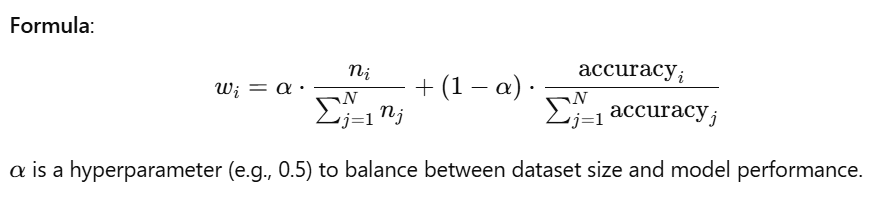

## Entropy-Based Weighting
In this method, we calculate the entropy of predictions for each model to measure uncertainty.
- **Lower entropy** implies higher confidence in predictions, and such models are given higher weight.
- **Higher entropy** implies lower confidence, resulting in lower weights.

The entropy for a prediction probability distribution is computed as:




**Fairness-Based Weighting**

***Concept: ***Ensure fairness by assigning weights inversely proportional to how much a client’s data overlaps with the global data distribution. Diverse clients receive higher weights.

***Technique:*** Use metrics like cosine similarity or Kullback-Leibler divergence to compare each client’s data distribution with the global distribution.

Assign equal weights to all clients when there is no clear reason to favor any specific client.
𝑤
𝑖
=
1
𝑁
w
i
​
 =
N
1
​



In [13]:
def aggregate_weights(client_weights, weight_factors):
    num_clients = len(client_weights)
    aggregated_weights = [np.zeros_like(client_weights[0]) for _ in range(len(client_weights[0]))]

    for client_index, weights in enumerate(client_weights):
        for layer_index, layer_weights in enumerate(weights):
            aggregated_weights[layer_index] += weight_factors[client_index] * np.array(layer_weights)

    return aggregated_weights


In [14]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import BackendSampler
from qiskit_algorithms.optimizers import SPSA
import numpy as np
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Callback function to visualize training progress
objective_func_vals = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Function to create the QNN model
def initialize_qnn_model(data_train):
    num_features = data_train[0]["sequence"].shape[0]
    # Define the quantum feature map and ansatz
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

    # Construct the quantum neural network using a sampler

    qc = feature_map.compose(ansatz)  # Build the QNN circuit
    print(f"Number of features (input dimension): {num_features}")
    print(f"Number of circuit parameters: {qc.num_parameters}")

    # Use parity as the interpretation function
    def parity(x):
        return "{:b}".format(x).count("1") % 2  # Binary classification

    # Explicitly define input_params and weight_params
    input_params = feature_map.parameters  # Parameters for the feature map (inputs)
    weight_params = ansatz.parameters      # Parameters for the ansatz (weights)
    #print(f"Input Parameters: {input_params}")
    #print(f"Weight Parameters: {weight_params}")

    sampler_qnn = SamplerQNN(
        circuit=qc,
        interpret=parity,
        output_shape=2,  # Output dimension for binary classification
        input_params=input_params,       # Pass input parameters
        weight_params=weight_params     # Pass weight parameters
    )

    # Define a classifier using the QNN
    qnn_classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=SPSA(maxiter=50,learning_rate=0.01, perturbation = 0.15),  # Example with SPSA optimizer
        #callback=callback_graph
    )

    return qnn_classifier


In [15]:

# Function to initialize a new QNN model (same architecture as clients' models)
def create_modal(num_features):
    # Create the same quantum neural network (QNN) architecture as clients
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)

    # Combine the feature map and ansatz into a single quantum circuit
    qc = feature_map.compose(ansatz)

    # Use parity as the interpretation function
    def parity(x):
        return "{:b}".format(x).count("1") % 2  # Binary classification

    # Explicitly define input_params and weight_params
    input_params = feature_map.parameters  # Input parameters (for encoding)
    weight_params = ansatz.parameters      # Trainable parameters (for optimization)

    # Define the QNN model using a sampler
    sampler_qnn = SamplerQNN(
        circuit=qc,
        interpret=parity,
        output_shape=2,  # Binary classification
        input_params=input_params,
        weight_params=weight_params
    )

    # Create a classifier using the neural network
    qnn_classifier = NeuralNetworkClassifier(
        neural_network=sampler_qnn,
        optimizer=SPSA(maxiter=50,learning_rate=0.01, perturbation = 0.15)  # Use SPSA optimizer
    )

    return qnn_classifier

# Function to create a global model with averaged weights
def create_model_with_weights(average_weights, num_features):
    # Initialize a new QNN model with the same architecture
    model = create_modal(num_features)
    # Assign the averaged weights to the model's trainable parameters (ansatz weights)
    weight_params = model.neural_network.weight_params  # Get the trainable parameters

    # Check if the lengths match, and truncate if necessary
    num_weights = min(len(average_weights), len(weight_params))

    # Create a dictionary mapping parameters to averaged weights
    param_dict = {param: average_weights[i] for i, param in enumerate(weight_params[:num_weights])}


    # Assign the averaged weights to the circuit parameters
    model.neural_network.circuit.assign_parameters(param_dict)

    return model

In [16]:
# Step to empty the CSV file before starting a new run
def clear_csv_file():
    """
    Clears the CSV file by overwriting it with headers or leaving it blank.
    """
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Uncomment the next line to write headers for the new run
        writer.writerow(headers)
        # Leave it blank if you prefer not to include headers
        # pass


In [17]:
def get_accuracy(model, test_sequences, test_labels):
    """
    Evaluate the accuracy of the given model on the test dataset.

    Parameters:
        model: The trained model to evaluate.
        num_features: The number of features in each data sample.
        test_sequences: A list or array of test input data (features).
        test_labels: A list or array of true labels corresponding to the test data.

    Returns:
        float: The accuracy of the model as a percentage.
    """
    test_accuracy = model.score(test_sequences, test_labels)
    return test_accuracy


In [18]:
import csv
# Lists to store accuracies over epochs
global_model_weights = {}
global_model_accuracy = []
clients_train_accuracies = []  # List to store train accuracies per epoch per client
clients_test_accuracies = []   # List to store test accuracies per epoch per client

# Function to train the QNN model for one client
def train_qnn_model(client_data,client_test_data, model=None):
    #num_features = client_data[0]["sequence"].shape[0]  # Get the feature dimension
    # Debug: Print the client data structure
    #for i, client in enumerate(clients):
        #print(f"Client {i} Test Data: {client.test_data}")
        #print(f"Test Data Length: {len(client.test_data)}")

    if model is None:
        # Create a new QNN model if one doesn't exist
        # Check if client_data is empty before creating the model
        # Check if client_data is empty before creating the model
        #if not client_data or all(not d for d in client_data):
          #print("Client data is empty. Skipping training for this client.")
          #return None, None, None, None  # Or handle appropriately

        model = initialize_qnn_model(client_data)

    # Extract sequences and labels for training
    train_sequences = [data_point["sequence"] for data_point in client_data]
    train_labels = [data_point["label"] for data_point in client_data]

    # Extract sequences and labels for testing
    # Handle test data
    if isinstance(client_test_data, dict):
        # Single data point (dictionary format)
        test_sequences = np.array([client_test_data["sequence"]])
        test_labels = np.array([client_test_data["label"]])
    else:
        # List of dictionaries (multiple data points)
        test_sequences = [data_point["sequence"] for data_point in client_test_data]
        test_labels = [data_point["label"] for data_point in client_test_data]
        test_sequences = np.array(test_sequences)
        test_labels = np.array(test_labels)
    # Debug: Print the first few test sequences and labels for verification
    #print("First few test sequences:", test_sequences[:2])
    #print("First few test labels:", test_labels[:2])
    # Convert lists to NumPy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)

    # Check if train_labels is empty before proceeding with training
    if len(train_labels) == 0:
        print("Training labels are empty. Skipping training for this client.")
        return model, None, None

    print("Training started...")
    start_time = time.time()

    # Train the QNN model
    model.fit(train_sequences, train_labels)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time} seconds.")

    # Evaluate the model on training and test data
    print(f"SCORING MODEL")
    train_score_q = model.score(train_sequences, train_labels)
    #test_score_q = model.score(test_sequences[:200], test_labels[:200])
    test_score_q = model.score(test_sequences, test_labels)

    return model, train_score_q, test_score_q, elapsed_time


Multple Weighting mechanisms


In [19]:
def compute_data_proportional_weights(client_data_sizes):
    total_data_size = sum(client_data_sizes)
    return [size / total_data_size for size in client_data_sizes]

def compute_accuracy_based_weights(client_accuracies):
    total_accuracy = sum(client_accuracies)
    return [acc / total_accuracy for acc in client_accuracies]

def compute_hybrid_weights(client_data_sizes, client_accuracies, alpha=0.5):
    data_weights = compute_data_proportional_weights(client_data_sizes)
    accuracy_weights = compute_accuracy_based_weights(client_accuracies)
    return [
        alpha * data_weight + (1 - alpha) * accuracy_weight
        for data_weight, accuracy_weight in zip(data_weights, accuracy_weights)
    ]

import numpy as np

def compute_entropy_based_weights(client_entropies):
    inv_entropies = [1 / entropy for entropy in client_entropies]
    total_inv_entropy = sum(inv_entropies)
    return [inv_entropy / total_inv_entropy for inv_entropy in inv_entropies]

def compute_fairness_weights(client_distributions, global_distribution):
    import scipy.stats

    kl_divergences = [
        scipy.stats.entropy(client_dist, global_distribution)
        for client_dist in client_distributions
    ]
    inv_kl_div = [1 / div for div in kl_divergences]
    total_inv_kl = sum(inv_kl_div)
    return [weight / total_inv_kl for weight in inv_kl_div]

def compute_equal_weights(num_clients):
    return [1 / num_clients] * num_clients



In [20]:
def compute_entropy_based_weights(client_data):
    """
    Compute entropy-based weights for clients.
    Entropy is calculated based on the distribution of labels in client data.

    Parameters:
    - client_data: List of data subsets for each client

    Returns:
    - List of normalized entropy weights
    """
    import scipy.stats

    entropies = []
    for data in client_data:
        labels = [sample[-1] for sample in data]  # Assuming labels are the last column
        label_counts = {label: labels.count(label) for label in set(labels)}
        probabilities = [count / len(labels) for count in label_counts.values()]
        entropy = scipy.stats.entropy(probabilities)
        entropies.append(entropy)

    # Normalize entropies to sum to 1
    total_entropy = sum(entropies)
    return [e / total_entropy for e in entropies]


In [21]:
def compute_fairness_weights(client_contributions):
    """
    Compute fairness-based weights for clients.
    Fairness can be based on contribution equity or other criteria.

    Parameters:
    - client_contributions: List of client contributions (e.g., data size, model performance)

    Returns:
    - List of normalized fairness weights
    """
    total_contribution = sum(client_contributions)
    return [1.0 / contribution if contribution > 0 else 0 for contribution in client_contributions]


In [22]:
import csv

def save_accuracies_to_csv(global_accuracy, clients_train_accuracies, clients_test_accuracies, filename="accuracies.csv"):
    """
    Saves accuracies to a CSV file.

    Args:
        global_accuracy (list): List of global model accuracies for each epoch.
        clients_train_accuracies (list): List of lists, where each inner list contains train accuracies for a client over epochs.
        clients_test_accuracies (list): List of lists, where each inner list contains test accuracies for a client over epochs.
        filename (str, optional): Name of the CSV file. Defaults to "accuracies.csv".
    """
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        # Write header
        header = ['Epoch', 'Global Accuracy'] + [f'Client {i} Train Accuracy' for i in range(len(clients_train_accuracies))] + [f'Client {i} Test Accuracy' for i in range(len(clients_test_accuracies))]
        writer.writerow(header)

        # Write data rows
        for epoch in range(len(global_accuracy)):
            row = [epoch + 1, global_accuracy[epoch]]  # Epoch starts from 1

            # Add client train accuracies for the epoch
            row.extend([clients_train_accuracies[i][epoch] if epoch < len(clients_train_accuracies[i]) else '' for i in range(len(clients_train_accuracies))])

            # Add client test accuracies for the epoch
            row.extend([clients_test_accuracies[i][epoch] if epoch < len(clients_test_accuracies[i]) else '' for i in range(len(clients_test_accuracies))])

            writer.writerow(row)

In [23]:
# Step to empty the CSV file before starting a new run
def clear_csv_file():
    """
    Clears the CSV file by overwriting it with headers or leaving it blank.
    """
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Uncomment the next line to write headers for the new run
        writer.writerow(headers)
        # Leave it blank if you prefer not to include headers
        # pass


In [25]:
def weighted_aggregation(
    epoch_weights,
    client_data_sizes=None,
    client_accuracies=None,
    client_entropies=None,
    global_distribution=None,
    num_features=None,
    weight_mechanism="fixed",
    **kwargs
):
    """
    Perform weighted aggregation of model weights with dynamic weighting mechanisms.

    Parameters:
    - epoch_weights: List of client weights for the epoch
    - client_data_sizes: List of sizes of data owned by each client
    - client_accuracies: List of accuracies achieved by each client
    - client_entropies: List of entropies of client predictions
    - global_distribution: Global data distribution for fairness-based weighting
    - weight_mechanism: The weighting mechanism to use ("data", "accuracy", "entropy", "fairness", "performance", "fixed")
    - num_features: The number of features in the model (added)
    - kwargs: Additional parameters for specific weighting mechanisms

    Returns:
    - aggregated_weights: Aggregated model weights
    """
    num_clients = len(epoch_weights)

    # Determine weights based on mechanism
    if weight_mechanism == "data":
        if not client_data_sizes:
            raise ValueError("Client data sizes must be provided for data-proportional weighting.")
        weights = compute_data_proportional_weights(client_data_sizes)

    elif weight_mechanism == "accuracy":
        if not client_accuracies:
            raise ValueError("Client accuracies must be provided for accuracy-based weighting.")
        weights = compute_accuracy_based_weights(client_accuracies)

    elif weight_mechanism == "entropy":
        if not client_entropies:
            raise ValueError("Client entropies must be provided for entropy-based weighting.")
        weights = compute_entropy_based_weights(client_entropies)

    elif weight_mechanism == "fairness":
        if not client_data_sizes or not global_distribution:
            raise ValueError("Client data sizes and global distribution must be provided for fairness-based weighting.")
        weights = compute_fairness_weights(client_data_sizes, global_distribution)

    elif weight_mechanism == "performance":
        if not client_accuracies or len(client_accuracies) != num_clients:
            raise ValueError("Client accuracies must be provided for performance-based weighting.")
        weights = client_accuracies  # Use accuracies directly as weights

    elif weight_mechanism == "hybrid":
        if not client_data_sizes or not client_accuracies:
            raise ValueError("Both client data sizes and accuracies must be provided for hybrid weighting.")
        weights = compute_hybrid_weights(client_data_sizes, client_accuracies, alpha=kwargs.get("alpha", 0.5))


    elif weight_mechanism == "fixed":
        best_client_index = kwargs.get("best_client_index", 0)
        best_client_weight_factor = kwargs.get("best_client_weight_factor", 1.5)
        weights = [best_client_weight_factor if i == best_client_index else 1 for i in range(num_clients)]

    else:
        raise ValueError(f"Unknown weighting mechanism: {weight_mechanism}")

    # Normalize weights
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]

    # Perform weighted aggregation
    aggregated_weights = np.zeros_like(epoch_weights[0])
    for i, client_weights in enumerate(epoch_weights):
        aggregated_weights += weights[i] * np.array(client_weights)

    return aggregated_weights
import csv
from google.colab import drive

def reset_state():
    # Reset the objective value, learning rate, and perturbation after each client
    global objective_func_vals, learning_rates, perturbations
    objective_func_vals = []  # Reset objective values
    learning_rates = []  # Reset learning rates
    perturbations = []  # Reset perturbations
# Function to reset callback graph state after each round
def reset_callback_graph():
    global gradient_moving_avg, learning_rates, perturbations

    # Reset the state variables to start fresh for the next round
    gradient_moving_avg = np.zeros_like(gradient_moving_avg)  # Reset gradient moving average
    learning_rates = [initial_learning_rate]  # Reset learning rates list to initial value
    perturbations = [initial_perturbation]  # Reset perturbations list to initial value

# Mount Google Drive if not already mounted
drive.mount('/content/drive')

# Path to store the best client's data
best_csv_file = '/content/drive/My Drive/QFL_Genome_Best_Client31.03.2025.csv'

# Write headers to the best client CSV file
bestheader = ["Federated Round", "Client Number"]

with open(best_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(bestheader)

# Function to update the best client data
def save_best_client_results(federated_round,best_client_index):
    """
    Save the best client's data to a separate CSV file.
    :param best_data: Dictionary containing the best client's data.
    """
    with open(best_csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([federated_round,
           best_client_index

        ])
# Clear the CSV file for a new run
#clear_csv_file()

global_model_weights = [None] * num_epochs # Initialize as a list to store weights for each epoch
global_model_accuracy = []
# Initialize client_train_accuracies and client_test_accuracies:
clients_train_accuracies = [[] for _ in range(num_clients)]
clients_test_accuracies = [[] for _ in range(num_clients)]
# Example usage in the federated learning loop
for epoch in range(num_epochs):
    global_model_weights[epoch] = []
    epoch_weights = []

    epoch_train_accuracies = []
    epoch_test_accuracies = []
    print("\n")
    print(f"Epoch: {epoch}")

    best_client_index = -1
    best_client_accuracy = -1

    # Train each client
    for index, client in enumerate(clients):
        print("\n")
        print(f"Training Client {index}")
        reset_state()

        model, train_score_q, test_score_q, train_time = train_qnn_model(client.data[epoch], client.test_data, model=client.primary_model)
        client.primary_model = model

        #client.train_scores.append(train_score_q)
        #client.test_scores.append(test_score_q)

        num_features = client.data[epoch][0]["sequence"].shape[0]

        print(f"Client {index} Train Score: {train_score_q}")
        print(f"Client {index} Test Score: {test_score_q}")

        # Append scores to clients_train_accuracies and clients_test_accuracies:
        clients_train_accuracies[index].append(train_score_q)
        clients_test_accuracies[index].append(test_score_q)

        epoch_train_accuracies.append(train_score_q)
        epoch_test_accuracies.append(test_score_q)

        if test_score_q is not None and test_score_q > best_client_accuracy:
            best_client_accuracy = test_score_q
            best_client_index = index
            best_client_model = model  # Directly store the best client's model

        # Collect model weights
        epoch_weights.append(model.weights)

    save_best_client_results(epoch,best_client_index)  # Save to best client CSV
    print(f"Best client for epoch {epoch} is Client {best_client_index} with test accuracy {best_client_accuracy:.2f}")

    # Treat the best client's model as the global model for the next round
    global_model = best_client_model
    # Update all clients with the global model
    for index, client in enumerate(clients):
        client.primary_model = global_model

    # Evaluate the global model on the new test data
    global_accuracy = get_accuracy(global_model, test_sequences, test_labels)
    global_model_accuracy.append(global_accuracy)

    clients_train_accuracies.append(epoch_train_accuracies)
    clients_test_accuracies.append(epoch_test_accuracies)

    print(f"Global Model Accuracy in Epoch {epoch}: {global_accuracy:.2f}")
    print("----------------------------------------------------------")


    # Save results for the current iteration of the client in the federated round
    from google.colab import drive

    # Step 1: Mount Google Drive
    drive.mount('/content/drive')

    # Step 2: Define the save path in Google Drive
    save_path = '/content/drive/MyDrive/QFL_Genome_global_31.03.2025.csv'


    # Save accuracies to CSV after each epoch (or at the end of all epochs)
    save_accuracies_to_csv(global_model_accuracy, clients_train_accuracies, clients_test_accuracies, filename=save_path)
    # After each round, reset callback state to prepare for the next round

    print(f"File saved to {save_path}")
    '''
    # Choose weighting mechanism
    weight_mechanism = "fixed"  # Can be "fixed", "performance", "dynamic", "entropy", or "fairness"

    if weight_mechanism == "fixed":
        aggregated_weights = weighted_aggregation(
        epoch_weights=epoch_weights,
        client_data_sizes=[len(client.data[epoch]) for client in clients],
        client_accuracies=epoch_test_accuracies,
        client_entropies=None,  # Add if available
        global_distribution=None,  # Add if required
        weight_mechanism=weight_mechanism,
        num_features=num_features,
        best_client_index=best_client_index,  # Only for "fixed"
        best_client_weight_factor=1.5  # Only for "fixed"
)


    elif weight_mechanism == "performance":
        aggregated_weights = weighted_aggregation(
        epoch_weights=epoch_weights,
        client_data_sizes=[len(client.data[epoch]) for client in clients],
        client_accuracies=epoch_test_accuracies,
        client_entropies=None,  # Add if available
        global_distribution=None,  # Add if required
        weight_mechanism=weight_mechanism,
        num_features=num_features,
        best_client_index=best_client_index,  # Only for "fixed"
        best_client_weight_factor=1.5  # Only for "fixed"
)

    elif weight_mechanism == "dynamic":
        aggregated_weights = weighted_aggregation(
            epoch_weights,
            best_client_index,
            weight_mechanism=weight_mechanism,
            accuracies=epoch_test_accuracies,
            beta=1.0,
            num_features=num_features  # Pass num_features here
        )

    elif weight_mechanism == "entropy":
        client_entropies = compute_entropy_based_weights(client.data[epoch])  # Compute entropy weights for clients
        aggregated_weights = weighted_aggregation(
            epoch_weights,
            best_client_index,
            weight_mechanism=weight_mechanism,
            entropies=client_entropies,  # Pass entropy-based weights
            num_features=num_features  # Pass num_features here
        )

    elif weight_mechanism == "fairness":
        fairness_weights = compute_fairness_weights(client_contributions)  # Compute fairness-based weights
        aggregated_weights = weighted_aggregation(
            epoch_weights,
            best_client_index,
            weight_mechanism=weight_mechanism,
            fairness_weights=fairness_weights,  # Pass fairness-based weights
            num_features=num_features  # Pass num_features here
        )

    else:
        raise ValueError(f"Unknown weighting mechanism: {weight_mechanism}")

    '''


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch: 0


Training Client 0
Number of features (input dimension): 5
Number of circuit parameters: 25
Training started...


<ipython-input-14-6e5ad0ddc26c>:45: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Training completed in 97.43499279022217 seconds.
SCORING MODEL
Client 0 Train Score: 0.47
Client 0 Test Score: 0.453


Training Client 1
Number of features (input dimension): 5
Number of circuit parameters: 25
Training started...


<ipython-input-14-6e5ad0ddc26c>:45: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Training completed in 96.13067197799683 seconds.
SCORING MODEL
Client 1 Train Score: 0.5
Client 1 Test Score: 0.529


Training Client 2
Number of features (input dimension): 5
Number of circuit parameters: 25
Training started...


<ipython-input-14-6e5ad0ddc26c>:45: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Training completed in 92.78450918197632 seconds.
SCORING MODEL
Client 2 Train Score: 0.58
Client 2 Test Score: 0.529


Training Client 3
Number of features (input dimension): 5
Number of circuit parameters: 25
Training started...


<ipython-input-14-6e5ad0ddc26c>:45: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Training completed in 94.40211153030396 seconds.
SCORING MODEL
Client 3 Train Score: 0.57
Client 3 Test Score: 0.545


Training Client 4
Number of features (input dimension): 5
Number of circuit parameters: 25
Training started...


<ipython-input-14-6e5ad0ddc26c>:45: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  sampler_qnn = SamplerQNN(


Training completed in 92.01271080970764 seconds.
SCORING MODEL
Client 4 Train Score: 0.46
Client 4 Test Score: 0.465
Best client for epoch 0 is Client 3 with test accuracy 0.55
Global Model Accuracy in Epoch 0: 0.53
----------------------------------------------------------
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File saved to /content/drive/MyDrive/QFL_Genome_global_31.03.2025.csv


Epoch: 1


Training Client 0
Training started...
Training completed in 93.04899096488953 seconds.
SCORING MODEL
Client 0 Train Score: 0.6
Client 0 Test Score: 0.565


Training Client 1
Training started...
Training completed in 92.08372187614441 seconds.
SCORING MODEL
Client 1 Train Score: 0.59
Client 1 Test Score: 0.52


Training Client 2
Training started...
Training completed in 93.05117297172546 seconds.
SCORING MODEL
Client 2 Train Score: 0.62
Client 2 Test Score: 0.507


Training Client 3
Training started...
Traini

In [ ]:
for epoch in range(num_epochs):
    epoch_weights = []
    epoch_train_accuracies = []
    epoch_test_accuracies = []

    print(f"\nEpoch: {epoch}")

    # Train each client
    for index, client in enumerate(clients):
        print(f"\nTraining Client {index}")
        model, train_score_q, test_score_q, train_time = train_qnn_model(
            client.data[epoch], client.test_data, model=client.primary_model
        )
        client.primary_model = model
        epoch_train_accuracies.append(train_score_q)
        epoch_test_accuracies.append(test_score_q)
        epoch_weights.append(model.weights)

    # Define client data sizes
    client_data_sizes = [len(client.data[epoch]) for client in clients]

    # Aggregate weights using hybrid weighting
    aggregated_weights = weighted_aggregation(
        epoch_weights=epoch_weights,
        client_data_sizes=client_data_sizes,
        client_accuracies=epoch_test_accuracies,
        weight_mechanism="hybrid",
        alpha=0.7  # Set the alpha value (e.g., 0.7 for 70% data, 30% accuracy)
    )

    # Update global model
    global_model_weights[epoch] = aggregated_weights
    epoch_global_Model = create_model_with_weights(global_model_weights[epoch], num_features)

    # Update client models
    for client in clients:
        client.primary_model = epoch_global_Model

    # Evaluate global model
    global_accuracy = getAccuracy(epoch_global_Model, num_features, test_sequences, test_labels)
    global_model_accuracy.append(global_accuracy)

    print(f"Global Model Accuracy in Epoch {epoch}: {global_accuracy:.2f}")
    print("----------------------------------------------------------")


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the CSV file
filename = 'accuracies.csv'
data = pd.read_csv(filename)

# Load the CSV file
#filename = 'bestclient.csv'
#datab = pd.read_csv(filename)

# Extract the relevant columns for plotting
epochs = data['Epoch']
global_accuracy = data['Global Accuracy']
client_train_accuracies = data.filter(like='Train Accuracy').values
client_test_accuracies = data.filter(like='Test Accuracy').values

# Extract the relevant columns for plotting
bepochs = datab['Epoch']
bglobal_accuracy = datab['Global Accuracy']
bclient_train_accuracies = datab.filter(like='Train Accuracy').values
bclient_test_accuracies = datab.filter(like='Test Accuracy').values

# Plot Global Accuracy over Epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, global_accuracy, label='Global Accuracy', color='blue', marker='o')
plt.plot(bepochs, bglobal_accuracy, label='Global Accuracy', color='red', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Global Accuracy')
plt.title('Global Accuracy Over Epochs')
plt.legend()

# Plot Global Accuracy over Epochs
plt.figure(figsize=(10, 6))
plt.plot(bepochs, bglobal_accuracy, label='Global Accuracy', color='blue', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Global Accuracy')
plt.title('Global Accuracy Over Epochs')
plt.legend()

plt.show()

# Plot Train Accuracies for all clients over Epochs
plt.figure(figsize=(10, 6))
for i in range(client_train_accuracies.shape[1]):
    plt.plot(epochs, client_train_accuracies[:, i], label=f'Client {i} Train Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')
plt.title('Train Accuracies for All Clients Over Epochs')
plt.legend()

plt.show()

# Plot Test Accuracies for all clients over Epochs
plt.figure(figsize=(10, 6))
for i in range(client_test_accuracies.shape[1]):
    plt.plot(epochs, client_test_accuracies[:, i], label=f'Client {i} Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracies for All Clients Over Epochs')
plt.legend()

plt.show()
